In [2]:
import sys, os
sys.path.insert(0,"../code")

import pandas as pd
import numpy as np
import geopandas as gpd
import pyproj
import matplotlib
import matplotlib.pyplot as plt
from pylab import*
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

%load_ext autoreload
%autoreload 2

# Unzip data and load into DataFrame 

In [3]:
def load_data(path_data="../data"): 
    
    if not os.path.exists(path_data): 
        os.mkdir(path)
    
    if not os.path.path.exists(os.path.join(path_data,"nyc-taxi-trip-duration")): 
        pass

In [4]:
PATH_DATA = os.path.join("../data","nyc-taxi-trip-duration","train.csv")

df_rides = pd.read_csv(PATH_DATA,index_col=0,parse_dates=[2,3],dtype={'store_and_fwd_flag':'category','vendor_id':'category','passenger_count':'int8',})
print(df_rides.info())
df_rides.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 10 columns):
vendor_id             1458644 non-null category
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int8
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null category
trip_duration         1458644 non-null int64
dtypes: category(2), datetime64[ns](2), float64(4), int64(1), int8(1)
memory usage: 93.2+ MB
None


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
## Split data into preliminary test and train in order to get an estimate without commiting to Kaggel 
df_train_sample = df_rides.sample(frac=0.15)
df_rides = df_rides.loc[set(df_rides.index)-set(df_train_sample.index)]
print(df_train_sample.shape)
print(df_rides.shape)
df_train_sample.to_pickle(os.path.join("../data","df_train_sample.pickle"))

(218797, 10)
(1239847, 10)


##  Basic data exploration 

In [6]:
print(df_rides.info())
df_rides.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1239847 entries, id1106725 to id0332844
Data columns (total 10 columns):
vendor_id             1239847 non-null category
pickup_datetime       1239847 non-null datetime64[ns]
dropoff_datetime      1239847 non-null datetime64[ns]
passenger_count       1239847 non-null int8
pickup_longitude      1239847 non-null float64
pickup_latitude       1239847 non-null float64
dropoff_longitude     1239847 non-null float64
dropoff_latitude      1239847 non-null float64
store_and_fwd_flag    1239847 non-null category
trip_duration         1239847 non-null int64
dtypes: category(2), datetime64[ns](2), float64(4), int64(1), int8(1)
memory usage: 79.2+ MB
None


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id1106725,1,2016-01-12 20:27:28,2016-01-12 20:35:07,1,-73.997536,40.761639,-73.987961,40.779484,N,459
id3696889,2,2016-03-22 22:07:26,2016-03-22 22:27:14,2,-73.975990,40.791077,-73.978714,40.750690,N,1188
id2834559,1,2016-02-21 10:53:56,2016-02-21 11:00:50,1,-73.961723,40.776794,-73.953300,40.764706,N,414
id1179086,1,2016-06-24 18:11:50,2016-06-24 18:20:49,1,-73.980331,40.761642,-73.959908,40.769527,N,539
id3738658,1,2016-04-07 07:49:26,2016-04-07 07:58:52,1,-73.998978,40.734325,-73.981552,40.758217,N,566


In [7]:
pd.isna(df_rides).sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [8]:
df_rides.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.239847e+06,1.239847e+06,1.239847e+06,1.239847e+06,1.239847e+06,1.239847e+06
mean,1.664401e+00,-7.397349e+01,4.075092e+01,-7.397344e+01,4.075180e+01,9.592064e+02
std,1.313863e+00,7.511450e-02,3.360399e-02,7.495360e-02,3.641171e-02,4.538723e+03
min,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399132e+01,4.073588e+01,3.970000e+02
50%,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075454e+01,6.620000e+02
75%,2.000000e+00,-7.396732e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,2.227612e+06


In [9]:
assert(df_rides.index.unique().shape[0]==df_rides.shape[0])
assert(np.all(df_rides.dropoff_datetime>df_rides.pickup_datetime))
assert(np.all(df_rides.passenger_count>=0))
#assert(np.allclose((df_rides.dropoff_datetime-df_rides.pickup_datetime).dt.seconds.values,df_rides.trip_duration,))

## Preprocessing of data

### Geographic data

In [10]:
from shapely.geometry import Point

def transform_to_geodf(df_rides,set_geometry_col='pickup'): 
        df_rides['pickup_geom'] = list(zip(df_rides.pickup_longitude,df_rides.pickup_latitude))
        df_rides['pickup_geom'] = df_rides['pickup_geom'].apply(Point)
        df_rides['dropoff_geom'] = list(zip(df_rides.dropoff_longitude,df_rides.dropoff_latitude))
        df_rides['dropoff_geom'] = df_rides['dropoff_geom'].apply(Point)
        df_rides = gpd.GeoDataFrame(df_rides,geometry=f'{set_geometry_col}_geom',crs={"init":"epsg:4326"})      
        return df_rides

In [11]:
df_rides = transform_to_geodf(df_rides)
df_rides.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_geom,dropoff_geom
id,,,,,,,,,,,,
id1106725,1,2016-01-12 20:27:28,2016-01-12 20:35:07,1,-73.997536,40.761639,-73.987961,40.779484,N,459,POINT (-73.99753570556641 40.76163864135742),POINT (-73.9879608154297 40.77948379516602)
id3696889,2,2016-03-22 22:07:26,2016-03-22 22:27:14,2,-73.975990,40.791077,-73.978714,40.750690,N,1188,POINT (-73.97599029541014 40.79107666015625),POINT (-73.97871398925781 40.75069046020508)
id2834559,1,2016-02-21 10:53:56,2016-02-21 11:00:50,1,-73.961723,40.776794,-73.953300,40.764706,N,414,POINT (-73.96172332763672 40.77679443359375),POINT (-73.95330047607422 40.76470565795898)
id1179086,1,2016-06-24 18:11:50,2016-06-24 18:20:49,1,-73.980331,40.761642,-73.959908,40.769527,N,539,POINT (-73.98033142089844 40.76164245605469),POINT (-73.95990753173827 40.76952743530273)
id3738658,1,2016-04-07 07:49:26,2016-04-07 07:58:52,1,-73.998978,40.734325,-73.981552,40.758217,N,566,POINT (-73.99897766113281 40.73432540893555),POINT (-73.98155212402342 40.75821685791016)


In [12]:
# Correct utm-zone: {'init': 'epsg:32618'}

def convert_projection_to_utm(df,col_x_source,col_y_source,
                              col_x_dest = 'x_utm', col_y_dest = 'y_utm',
                              projection_source=pyproj.Proj("+init=EPSG:4326"),
                              projection_dest=pyproj.Proj("+init=EPSG:32618")): 
    x,y = pyproj.transform(projection_source, projection_dest,df[col_x_source].values,df[col_y_source].values)
    return df.assign(**{col_x_dest:x,col_y_dest:y})

df_rides = convert_projection_to_utm(df_rides,col_x_source='pickup_longitude',col_y_source='pickup_latitude',col_x_dest="pickup_x_utm",col_y_dest='pickup_y_utm')
df_rides = convert_projection_to_utm(df_rides,col_x_source='dropoff_longitude',col_y_source='dropoff_latitude',col_x_dest="dropoff_x_utm",col_y_dest='dropoff_y_utm')
df_rides.head()


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_geom,dropoff_geom,pickup_x_utm,pickup_y_utm,dropoff_x_utm,dropoff_y_utm
id,,,,,,,,,,,,,,,,
id1106725,1,2016-01-12 20:27:28,2016-01-12 20:35:07,1,-73.997536,40.761639,-73.987961,40.779484,N,459,POINT (-73.99753570556641 40.76163864135742),POINT (-73.9879608154297 40.77948379516602),584612.422004,4.512781e+06,585397.745433,4.514771e+06
id3696889,2,2016-03-22 22:07:26,2016-03-22 22:27:14,2,-73.975990,40.791077,-73.978714,40.750690,N,1188,POINT (-73.97599029541014 40.79107666015625),POINT (-73.97871398925781 40.75069046020508),586392.830299,4.516069e+06,586215.227081,4.511584e+06
id2834559,1,2016-02-21 10:53:56,2016-02-21 11:00:50,1,-73.961723,40.776794,-73.953300,40.764706,N,414,POINT (-73.96172332763672 40.77679443359375),POINT (-73.95330047607422 40.76470565795898),587615.282804,4.514498e+06,588342.070398,4.513165e+06
id1179086,1,2016-06-24 18:11:50,2016-06-24 18:20:49,1,-73.980331,40.761642,-73.959908,40.769527,N,539,POINT (-73.98033142089844 40.76164245605469),POINT (-73.95990753173827 40.76952743530273),586064.557564,4.512798e+06,587778.076299,4.513693e+06
id3738658,1,2016-04-07 07:49:26,2016-04-07 07:58:52,1,-73.998978,40.734325,-73.981552,40.758217,N,566,POINT (-73.99897766113281 40.73432540893555),POINT (-73.98155212402342 40.75821685791016),584525.292748,4.509747e+06,585965.936759,4.512416e+06


In [13]:
def calc_distance(df,col_x1_utm,col_x2_utm,col_y1_utm,col_y2_utm,type_='beeline'): 
    if type_ =='beeline': 
        distance = np.sqrt((df[col_x1_utm]-df[col_x2_utm])**2+(df[col_y1_utm]-df[col_y2_utm])**2) 
    elif type_ =='manhattan': 
        distance = np.abs((df[col_x1_utm]-df[col_x2_utm]))+np.abs((df[col_y1_utm]-df[col_y2_utm]))
    return df.assign(**{f"distance_{type_}":distance})

df_rides = calc_distance(df_rides,
                         col_x1_utm='pickup_x_utm',col_x2_utm='dropoff_x_utm',
                         col_y1_utm='pickup_y_utm',col_y2_utm="dropoff_y_utm",
                         type_='beeline')

df_rides = calc_distance(df_rides,
                         col_x1_utm='pickup_x_utm',col_x2_utm='dropoff_x_utm',
                         col_y1_utm='pickup_y_utm',col_y2_utm="dropoff_y_utm",
                         type_='manhattan')

assert(np.all(df_rides.distance_beeline<=df_rides.distance_manhattan))
df_rides.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_geom,dropoff_geom,pickup_x_utm,pickup_y_utm,dropoff_x_utm,dropoff_y_utm,distance_beeline,distance_manhattan
id,,,,,,,,,,,,,,,,,,
id1106725,1,2016-01-12 20:27:28,2016-01-12 20:35:07,1,-73.997536,40.761639,-73.987961,40.779484,N,459,POINT (-73.99753570556641 40.76163864135742),POINT (-73.9879608154297 40.77948379516602),584612.422004,4.512781e+06,585397.745433,4.514771e+06,2139.563346,2775.549151
id3696889,2,2016-03-22 22:07:26,2016-03-22 22:27:14,2,-73.975990,40.791077,-73.978714,40.750690,N,1188,POINT (-73.97599029541014 40.79107666015625),POINT (-73.97871398925781 40.75069046020508),586392.830299,4.516069e+06,586215.227081,4.511584e+06,4489.373161,4663.461940
id2834559,1,2016-02-21 10:53:56,2016-02-21 11:00:50,1,-73.961723,40.776794,-73.953300,40.764706,N,414,POINT (-73.96172332763672 40.77679443359375),POINT (-73.95330047607422 40.76470565795898),587615.282804,4.514498e+06,588342.070398,4.513165e+06,1518.698812,2060.288953
id1179086,1,2016-06-24 18:11:50,2016-06-24 18:20:49,1,-73.980331,40.761642,-73.959908,40.769527,N,539,POINT (-73.98033142089844 40.76164245605469),POINT (-73.95990753173827 40.76952743530273),586064.557564,4.512798e+06,587778.076299,4.513693e+06,1933.420641,2609.045908
id3738658,1,2016-04-07 07:49:26,2016-04-07 07:58:52,1,-73.998978,40.734325,-73.981552,40.758217,N,566,POINT (-73.99897766113281 40.73432540893555),POINT (-73.98155212402342 40.75821685791016),584525.292748,4.509747e+06,585965.936759,4.512416e+06,3033.028889,4109.690484


In [14]:
df_rides['avg_speed_kmh'] = (df_rides.distance_manhattan*1e-3)/ (df_rides.trip_duration*1/3600)

In [15]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()

def calc_time_features(df,index_col='pickup_datetime',flg_days_before_after=False): 
    ind = df.set_index(index_col,drop='False').index
    holidays = pd.DataFrame(cal.holidays(start=str(ind.year.min()), end=str(ind.year.max()+1),return_name=True)).rename(columns={0:"holiday_name"})
    if flg_days_before_after: 
        holidays = pd.concat([holidays,
                             "Day Before " + holidays.shift(-1, 'D'),
                             "Day After " + holidays.shift(1, 'D')])
    #holidays.name = 'holiday_name'  # required for join
    df['day_of_week'] = ind.dayofweek 
    df['season'] = (ind.month % 12 + 3) // 3
    df['season'] = ind.quarter
    df['month'] = ind.month
    df['day_of_year'] = ind.dayofyear
    df['is_weekend'] = ind.dayofweek>5
    df['hour'] = ind.hour
    df['date'] = pd.DatetimeIndex(ind.date)
    df['id'] = df.index
    df = df.set_index("date",drop=False).join(holidays,how='left').set_index("id",drop=False)
    df['is_holiday'] = 0 
    df['is_holiday'] = ~(pd.isna(df['holiday_name']))
    return df

df_rides = calc_time_features(df_rides)

In [16]:
df_rides.holiday_name.value_counts()

Presidents Day                6259
New Years Day                 6062
Dr. Martin Luther King Jr.    6051
MemorialDay                   4689
Name: holiday_name, dtype: int64

In [17]:
#To-Do: Compare numba to numpy 
def calc_hours_daylight(df,col_latitude='pickup_latitude',col_day_of_year = "day_of_year"):
    P = np.arcsin(0.39795 * np.cos(0.2163108 + 2 * np.arctan(0.9671396 * np.tan(.00860 * (df[col_day_of_year].astype(int)-186)))))
    hours_daylight = 24 - (24 / np.pi) * np.arccos(
        (np.sin((0.8333 * np.pi / 180) + np.sin(df[col_latitude] * np.pi / 180) * np.sin(P)) / (np.cos(df[col_latitude] * np.pi / 180) * np.cos(P))))
    return df.assign(**{"hours_daylight": hours_daylight})

df_rides = calc_hours_daylight(df_rides)

In [18]:
def calc_cell_id(df,col_x_utm,col_y_utm,col_id='Cell_ID',cell_length=100,keep_coordinates_center=True): 
    df[f"x_sw_utm_{col_id}"] = ((df[col_x_utm].values//cell_length)*cell_length).astype(int)
    df[f"y_sw_utm_{col_id}"] = ((df[col_y_utm].values//cell_length)*cell_length).astype(int)
    df[col_id] = f"{cell_length}mN"+(df[f"x_sw_utm_{col_id}"]//cell_length).astype(str)+"E"+(df[f"y_sw_utm_{col_id}"]//cell_length).astype(str)
    if not keep_coordinates_center: 
        df.drop(columns=[f"x_sw_utm_{col_id}",f"y_sw_utm_{col_id}"],inplace=True)
    return df

df_rides = calc_cell_id(df_rides,col_x_utm="dropoff_x_utm",col_y_utm="dropoff_y_utm",col_id='Cell_ID_dropoff')
df_rides = calc_cell_id(df_rides,col_x_utm="pickup_x_utm",col_y_utm="pickup_y_utm",col_id='Cell_ID_pickup')
df_rides.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,id,holiday_name,is_holiday,hours_daylight,x_sw_utm_Cell_ID_dropoff,y_sw_utm_Cell_ID_dropoff,Cell_ID_dropoff,x_sw_utm_Cell_ID_pickup,y_sw_utm_Cell_ID_pickup,Cell_ID_pickup
id,,,,,,,,,,,,,,,,,,,,,
id0347462,2,2016-01-01 03:18:58,2016-01-01 03:22:08,6,-73.981773,40.752441,-73.988548,40.743141,N,190,...,id0347462,New Years Day,True,9.326489,585300,4510700,100mN5853E45107,585900,4511700,100mN5859E45117
id1039497,2,2016-01-01 00:34:39,2016-01-01 00:51:48,1,-73.967216,40.756901,-73.991806,40.767860,N,1029,...,id1039497,New Years Day,True,9.326040,585000,4513400,100mN5850E45134,587100,4512200,100mN5871E45122
id3110436,1,2016-01-01 03:50:24,2016-01-01 04:00:32,1,-73.985527,40.747288,-73.950089,40.785599,N,608,...,id3110436,New Years Day,True,9.327008,588500,4515400,100mN5885E45154,585600,4511100,100mN5856E45111
id1880207,1,2016-01-01 00:09:55,2016-01-01 01:09:37,4,-73.988571,40.758755,-73.864708,40.834286,N,3582,...,id1880207,New Years Day,True,9.325853,595700,4520900,100mN5957E45209,585300,4512400,100mN5853E45124
id1667535,1,2016-01-01 16:55:30,2016-01-01 17:01:08,1,-73.983772,40.738140,-73.987625,40.722572,N,338,...,id1667535,New Years Day,True,9.327928,585400,4508400,100mN5854E45084,585800,4510100,100mN5858E45101


In [19]:
def aggregate_by_ID(df,col_groupby,agg_funcs={'passenger_count':['sum','mean'],'trip_duration':['sum','mean']}):
    agg_funcs = {**agg_funcs,**{f"x_sw_utm_{col_groupby}":'first',f"y_sw_utm_{col_groupby}":'first'}}
    df = df.groupby(col_groupby).agg(agg_funcs)
    df.columns = [f"{agg_func}_{col}" for col,agg_func 
                  in zip(df.columns.get_level_values(level=0),df.columns.get_level_values(level=1))]
    df.rename(columns={c:c.replace("first_","") for c in df.columns},inplace=True)
    return df

In [20]:
df_cells = (aggregate_by_ID(df_rides,
                            col_groupby="Cell_ID_pickup")
            .join(aggregate_by_ID(df_rides,
                                  col_groupby='Cell_ID_dropoff'),
                  how='outer',lsuffix='_pickup',rsuffix='_dropoff')
           )
df_cells.head()

,sum_passenger_count_pickup,mean_passenger_count_pickup,sum_trip_duration_pickup,mean_trip_duration_pickup,x_sw_utm_Cell_ID_pickup,y_sw_utm_Cell_ID_pickup,sum_passenger_count_dropoff,mean_passenger_count_dropoff,sum_trip_duration_dropoff,mean_trip_duration_dropoff,x_sw_utm_Cell_ID_dropoff,y_sw_utm_Cell_ID_dropoff
100mN-37336E53461,4.0,2.0,1604.0,802.0,-3733600.0,5346100.0,4.0,2.0,1604.0,802.0,-3733600.0,5346100.0
100mN10602E40150,1.0,1.0,385.0,385.0,1060200.0,4015000.0,1.0,1.0,385.0,385.0,1060200.0,4015000.0
100mN11396E49446,1.0,1.0,1131.0,1131.0,1139600.0,4944600.0,NaN,NaN,NaN,NaN,NaN,NaN
100mN1190E46139,1.0,1.0,548.0,548.0,119000.0,4613900.0,NaN,NaN,NaN,NaN,NaN,NaN
100mN1210E45194,2.0,2.0,445.0,445.0,121000.0,4519400.0,2.0,2.0,445.0,445.0,121000.0,4519400.0


In [21]:
df_cells.to_pickle(os.path.join("../data","df_cells.pickle"))

In [22]:
df_rides.to_pickle(os.path.join("../data","df_rides.pickle"))

In [37]:
df_rides.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,id,holiday_name,is_holiday,hours_daylight,x_sw_utm_Cell_ID_dropoff,y_sw_utm_Cell_ID_dropoff,Cell_ID_dropoff,x_sw_utm_Cell_ID_pickup,y_sw_utm_Cell_ID_pickup,Cell_ID_pickup
id,,,,,,,,,,,,,,,,,,,,,
id0347462,2,2016-01-01 03:18:58,2016-01-01 03:22:08,6,-73.981773,40.752441,-73.988548,40.743141,N,190,...,id0347462,New Years Day,True,9.326489,585300,4510700,100mN5853E45107,585900,4511700,100mN5859E45117
id1039497,2,2016-01-01 00:34:39,2016-01-01 00:51:48,1,-73.967216,40.756901,-73.991806,40.767860,N,1029,...,id1039497,New Years Day,True,9.326040,585000,4513400,100mN5850E45134,587100,4512200,100mN5871E45122
id3110436,1,2016-01-01 03:50:24,2016-01-01 04:00:32,1,-73.985527,40.747288,-73.950089,40.785599,N,608,...,id3110436,New Years Day,True,9.327008,588500,4515400,100mN5885E45154,585600,4511100,100mN5856E45111
id1880207,1,2016-01-01 00:09:55,2016-01-01 01:09:37,4,-73.988571,40.758755,-73.864708,40.834286,N,3582,...,id1880207,New Years Day,True,9.325853,595700,4520900,100mN5957E45209,585300,4512400,100mN5853E45124
id1667535,1,2016-01-01 16:55:30,2016-01-01 17:01:08,1,-73.983772,40.738140,-73.987625,40.722572,N,338,...,id1667535,New Years Day,True,9.327928,585400,4508400,100mN5854E45084,585800,4510100,100mN5858E45101


In [39]:
def ecdf(data):
    """
        This methods caculcates the x,y coordinates for an ecdf-plot

    parameters:
        data: numpy array of pandas series of data

    return parameters:
        sorted numpy array of values, numpy array of percentage of values below indexed value

    """
    if type(data) is np.ndarray:
        data = data[~np.isnan(data)]
        return np.sort(data), np.arange(1, len(data) + 1) / len(data)
    else:
        data = data.dropna()
        return np.sort(data.values), np.arange(1, len(data.values) + 1) / len(data.values)

def plot_ecdf(x=None, y=None, series=None,
              ax=None, xlim=None, xlabel=None, flg_annotation=True, flg_median=True, flg_interquartile_range=False,
              flg_ylabel=True, label=None,
              path=None, **kwargs):
    """

    :param x                            numpy array or pandas series of x-values for ecdf curve
    :param y:                           numpy array or pandas series of y-values for ecdf curve
    :param series                       pandas series for which to calculate the ecdf curve
    :param ax:                          axis object on which ecdf curve is to be plotted
    :param xlim:                        tuple of x limits of plot
    :param xlabel:                      string xlabel of plot
    :param flg_annotation:              boolean for annotation in title
    :param flg_median:                  boolean if hline of median to be plotted
    :param flg_interquartile_range:     boolean if hlines of interquartile range to be plotted
    :param flg_ylabel:                  boolean if ylabel to be displayed
    :param label:                       string legend label
    :param path:                        string for save path
    :param kwargs:                      kwargs for scatterplot
    :return:                            axis object on which ecdf curve is plotted
    """

    if series is not None:
        x, y = ecdf(series)
    if ax is None:
        f, ax = plt.subplots(1, 1)
    ax.scatter(x, y, label=label, **kwargs)

    if flg_median:
        ax.vlines(np.nanmedian(x), 0, 0.5, linestyles="--")
    if flg_interquartile_range:
        ax.vlines(np.nanpercentile(x, 25), 0, 0.25, linestyles="--")
        ax.vlines(np.nanpercentile(x, 75), 0, 0.75, linestyles="--")
    if xlim is not None:
        ax.set_xlim(xlim)
    else:
        xlim = ax.get_xlim()
    if flg_annotation:
        ax.set_title(f"Contains {y[x<xlim[1]][-1]*100:.2f} % of all measurements")
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if flg_ylabel:
        ax.set_ylabel("Cumulative density")

    if path is not None:
        ax.get_figure().savefig(path, dpi=600)

    return ax

In [45]:
def convert_projection_to_utm(df,col_x_source,col_y_source,
                              col_x_dest = 'x_utm', col_y_dest = 'y_utm',
                              projection_source=pyproj.Proj("+init=EPSG:4326"),
                              projection_dest=pyproj.Proj("+init=EPSG:32618")): 
    x,y = pyproj.transform(projection_source, projection_dest,df[col_x_source].values,df[col_y_source].values)
    return df.assign(**{col_x_dest:x,col_y_dest:y})

df_rides = convert_projection_to_utm(df_rides,col_x_source='pickup_longitude',col_y_source='pickup_latitude',col_x_dest="pickup_x_utm",col_y_dest='pickup_y_utm')
df_rides = convert_projection_to_utm(df_rides,col_x_source='dropoff_longitude',col_y_source='dropoff_latitude',col_x_dest="dropoff_x_utm",col_y_dest='dropoff_y_utm')
df_rides.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,id,holiday_name,is_holiday,hours_daylight,x_sw_utm_Cell_ID_dropoff,y_sw_utm_Cell_ID_dropoff,Cell_ID_dropoff,x_sw_utm_Cell_ID_pickup,y_sw_utm_Cell_ID_pickup,Cell_ID_pickup
id,,,,,,,,,,,,,,,,,,,,,
id0347462,2,2016-01-01 03:18:58,2016-01-01 03:22:08,6,-73.981773,40.752441,-73.988548,40.743141,N,190,...,id0347462,New Years Day,True,9.326489,585300,4510700,100mN5853E45107,585900,4511700,100mN5859E45117
id1039497,2,2016-01-01 00:34:39,2016-01-01 00:51:48,1,-73.967216,40.756901,-73.991806,40.767860,N,1029,...,id1039497,New Years Day,True,9.326040,585000,4513400,100mN5850E45134,587100,4512200,100mN5871E45122
id3110436,1,2016-01-01 03:50:24,2016-01-01 04:00:32,1,-73.985527,40.747288,-73.950089,40.785599,N,608,...,id3110436,New Years Day,True,9.327008,588500,4515400,100mN5885E45154,585600,4511100,100mN5856E45111
id1880207,1,2016-01-01 00:09:55,2016-01-01 01:09:37,4,-73.988571,40.758755,-73.864708,40.834286,N,3582,...,id1880207,New Years Day,True,9.325853,595700,4520900,100mN5957E45209,585300,4512400,100mN5853E45124
id1667535,1,2016-01-01 16:55:30,2016-01-01 17:01:08,1,-73.983772,40.738140,-73.987625,40.722572,N,338,...,id1667535,New Years Day,True,9.327928,585400,4508400,100mN5854E45084,585800,4510100,100mN5858E45101


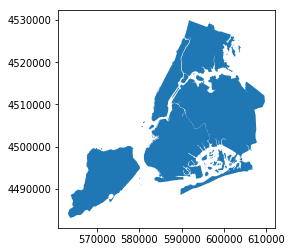

In [48]:
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.GeoDataFrame.from_file(nybb_path)
boros = boros.set_index('BoroCode')
boros = boros.sort_index().to_crs({'init': 'epsg:32618'})

(4475000, 4540000)

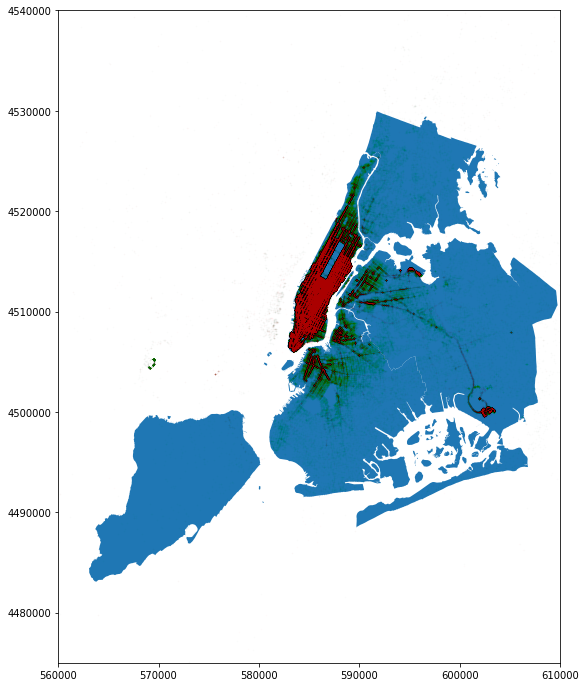

In [72]:
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.GeoDataFrame.from_file(nybb_path)
boros = boros.set_index('BoroCode')
boros = boros.sort_index().to_crs({'init': 'epsg:32618'})

f,ax = plt.subplots(1,1,figsize=(12,12))                                        
boros.plot(ax=ax)
df_scatter = df_rides.sample(10000)
ax.scatter(df_rides.dropoff_x_utm,df_rides.dropoff_y_utm,alpha=0.01, marker='.',s=1,c='g')
ax.scatter(df_rides.pickup_x_utm,df_rides.pickup_y_utm,alpha=0.01, marker='.',s=1,c='r')
ax.set_xlim([560000, 610000])
ax.set_ylim([4475000, 4540000])

In [ ]:
                                        
f,ax = plt.subplots(1,1, figsize=(12,12))
boros.plot(ax=ax)
ax.plot(np.stack((df_rides.pickup_x_utm,df_rides.dropoff_x_utm)),np.stack((df_rides.pickup_y_utm,df_rides.dropoff_y_utm)),c='r'); 
ax.set_xlim([560000, 610000])
ax.set_ylim([4475000, 4540000])